
## <font color=red> You should not import any new libraries. Your code should run with python=3.x</font>
## <font color=red> Please don't rename this .ipynb file.</font><br>
- Your solutions will be auto-graded. Hence we request you to follow the instructions.
- Modify the code only between 
```
## TODO
## END TODO
```
- In addition to above changes, you can play with arguments to the functions for generating plots
- We will run the auto grading scripts with private test data

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.linalg import inv # use this function to invert matrices

c:\users\aakri\appdata\local\programs\python\python37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\users\aakri\appdata\local\programs\python\python37\lib\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
c:\users\aakri\appdata\local\programs\python\python37\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
c:\users\aakri\appdata\local\programs\python\python37\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


## Please make sure that your code works with loading data from relative path only

i.e. ```pd.read_csv('./data/single_var_new.csv')``` should not throw an error when we run the auto-grading scripts

In [2]:
data_single = pd.read_csv('./data/single_var.csv')
X_single = np.array(data_single['x_gt'])
Y_single = np.array(data_single['y_gt'])

data_multi = pd.read_csv('./data/multi_var.csv')
cols = [f"x_gt_{idx}" for idx in range(1, 6)]
X_multi = np.array(data_multi[cols])
Y_multi = np.array(data_multi['y_gt'])

## Plot Graphs

- This function plots the ground truth curve in <font color=green>green</font> and the predicted function in <font color=red>red</font>

In [3]:
def plot_curves(w, b, x, y):
  '''
  Plots the curves for groud truth function and the fitted function

  Args:
  w - list of parameters
  b - float
  x - data features
  y - output value
  '''

  assert type(w) == type([0]), f'Please pass a list of parameters to plot_curves and not {type(w)}'

  x_gt = np.linspace(-1, 2, 50)
  y_gt = 1 - 3 * x_gt - 2 * x_gt ** 2 + 2.5 * x_gt ** 3

  if len(w) == 1:
    y_fit = w * x_gt + b
  elif len(w) == 5:
    x_fit = x_gt
    for pow in range(2, 4):
      x_fit = np.vstack([x_fit, np.power(x_gt, pow)])
    
    x_fit = np.vstack([x_fit, np.sin(np.pi * 2 * x_gt)])
    x_fit = np.vstack([x_fit, np.cos(np.pi * x_gt)])
    y_fit = np.dot(w, x_fit) + b
  else:
    assert False, 'Pass a valid w'
  plt.plot(x_gt, y_gt, color="green", label='1 - 3 * x - 2 * x ** 2 + 2.5 * x ** 3')
  plt.plot(x_gt, y_fit, color='red', label="Fitted Function y = w.Tx + b")
  if len(x.shape) == 1:
    x_plot = np.vstack([x, np.ones(len(x))]).T
  else:
    x_plot = x
  plt.scatter(x_plot[:,0],y)
  plt.legend()
  plt.title("OLS")
  plt.show()

## Split data into train/validation
- make sure that training and validation datasets are disjoint
- Split data into train and validation sets such that train contains floor(n_sampes * train_ratio) and test contains the remaining samples

In [4]:
def split_data(X, Y, train_ratio=0.6):
    '''
    Split data into train and validation sets such that train
    contains floor(n_sampes * train_ratio) and test contains the remaining
    samples

    Args:
    X - numpy array of shape (n_samples, n_features)
    Y - numpy array of shape (n_samples, 1)
    train_ratio - fraction of samples to be used as training data

    Returns:
    X_train, Y_train, X_val, Y_val
    '''

    ## TODO
    split_val = int(len(Y)*train_ratio)
    rng = np.random.default_rng(seed=420)
    arr = np.arange(len(Y))
    rng.shuffle(arr)
    X = X[arr]
    Y = Y[arr]
    X_train = X[:split_val]
    Y_train = Y[:split_val]
    X_val = X[split_val:]
    Y_val = Y[split_val:]

    
    ## END TODO
    
    return X_train, Y_train, X_val, Y_val

## mse for single variable regression

In [5]:
def mse_single_var(X, Y, w, b):
    '''
    Compute mean squared error between predictions and true y values

    Args:
    X - numpy array of shape (n_samples, 1)
    Y - numpy array of shape (n_samples, 1)
    w - a float
    b - a float
    '''

    ## TODO
    
    mse = np.mean(np.square(w*X + b - Y))

    ## END TODO

    return mse

In [6]:
def mse_multi_var(X, Y, w, b):
    '''
    Compute mean squared error between predictions and true y values

    Args:
    X - numpy array of shape (n_samples, 5)
    Y - numpy array of shape (n_samples, 1)
    w - list of parameters
    b - a float
    '''

    ## TODO
    
    w = np.array(w)
    y_hat = np.matmul(X, w) + b
    mse = np.mean(np.square(y_hat - Y))
    
    ## END TODO

    return mse

In [7]:
def mse_regularized(X, Y, w, b, lamda=0.005):
    '''
    Compute mean squared error between predictions and true y values

    Args:
    X - numpy array of shape (n_samples, 5)
    Y - numpy array of shape (n_samples, 1)
    w - list of parameters
    b - a float
    '''

    ## TODO

    w = np.array(w)
    mse = np.mean(np.square(np.matmul(X, w) + b - Y)) + lamda*np.sum(np.square(w))

    ## END TODO

    return mse

# Single Variable Regression

In [8]:
def singlevar_grad(X_train, Y_train, X_val, Y_val, epochs=1000, lr=0.01):
    '''
    Perform single variable least squares regression using gradient descent

    Args:
    X_train - numpy array of shape (n_samples_train, 1)
    Y_train - numpy array of shape (n_samples_train, 1)
    X_val - numpy array of shape (n_samples_val, 1)
    Y_val - numpy array of shape (n_samples_val, 1)
    epochs - number of gradient descent steps
    lr - learnig rate
    '''

    # Initialize the parameters with 0
    w = 0
    b = 0

    ## TODO

    n = len(Y_train)
    for i in range(epochs):
        y_pred = w*X_train + b
        dw = 2*(np.matmul((y_pred - Y_train), X_train))/n
        db = 2*np.sum(y_pred - Y_train)/n
        w -= lr*dw
        b -= lr*db
        
    ## END TODO

    mse_train = mse_single_var(X_train, Y_train, w, b)
    mse_val = mse_single_var(X_val, Y_val, w, b)
    print(f'Validation loss is {mse_val}')
    print(f'Training Loss loss is {mse_train}')
    plot_curves([w], b, X_train, Y_train)
    return w, b


def singlevar_closedform(X_train, Y_train, X_val, Y_val):
    '''
    Perform single variable least squares regression using closed form update 
    rules

    Args:
    X_train - numpy array of shape (n_samples_train, 1)
    Y_train - numpy array of shape (n_samples_train, 1)
    X_val - numpy array of shape (n_samples_val, 1)
    Y_val - numpy array of shape (n_samples_val, 1)
    '''

    w = 0
    b = 0

    ## TODO
        
    X = X_train.reshape(X_train.shape[0], 1)
    X = np.hstack((X, np.ones((X_train.shape[0], 1), dtype=X_train.dtype)))
    w_b = np.dot(inv(np.dot(X.T, X)), np.dot(X.T, Y_train))
    w = w_b[0]
    b = w_b[-1]
    
    ## END TODO


    mse_train = mse_single_var(X_train, Y_train, w, b)
    mse_val = mse_single_var(X_val, Y_val, w, b)
    print(f'Validation loss is {mse_val}')
    print(f'Training Loss loss is {mse_train}')
    plot_curves([w], b, X_train, Y_train)
    return w, b

Validation loss is 3.921802393877462
Training Loss loss is 1.1926998680458005


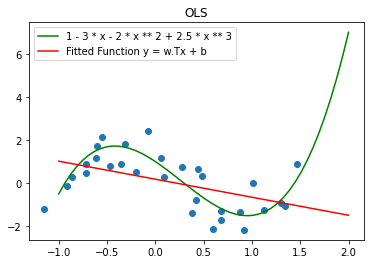

------------------------------------------------------------------------------------------------------------------------
Validation loss is 3.9338188299571883
Training Loss loss is 1.1926891877346768


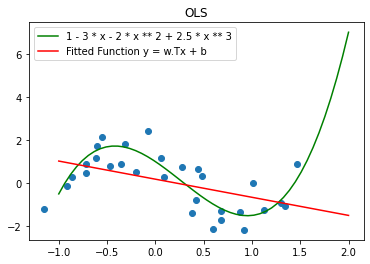

(-0.8403138556511941, 0.18297213536573662)

In [9]:
X_train, Y_train, X_val, Y_val = split_data(X_single, Y_single, train_ratio=0.6)

singlevar_grad(X_train, Y_train, X_val, Y_val, epochs=500, lr=0.01)

print('----'*30)

singlevar_closedform(X_train, Y_train, X_val, Y_val)

# Multi Variable Regression


In [10]:
def multivar_grad(X_train, Y_train, X_val, Y_val, epochs=1000, lr=0.1):
    '''
    Perform multi variable least squares regression using gradient descent

    Args:
    X_train - numpy array of shape (n_samples_train, 5)
    Y_train - numpy array of shape (n_samples_train, 1)
    X_val - numpy array of shape (n_samples_val, 5)
    Y_val - numpy array of shape (n_samples_val, 1)
    epochs - number of gradient descent steps
    lr - learnig rate
    '''

    w = [0.0] * X_train.shape[1]
    b = 0

    ## TODO

    n = len(Y_train)
    for i in range(epochs):
        
        w = np.array(w)
        y_pred = np.matmul(X_train, w) + b
        dw = 2*(np.matmul((y_pred - Y_train), X_train))/n
        db = 2*np.sum(y_pred - Y_train)/n
        w -= lr*dw
        b -= lr*db

    ### END TODO
    
    mse_train = mse_multi_var(X_train, Y_train, w, b)
    mse_val = mse_multi_var(X_val, Y_val, w, b)
    print(f'Validation loss if {mse_val}')
    print(f'Training Loss loss if {mse_train}')
    plot_curves(list(w), b, X_train, Y_train)
    return w, b



def multivar_closedform(X_train, Y_train, X_val, Y_val):
    '''
    Perform multi variable least squares regression using closed form 
    updates

    Args:
    X_train - numpy array of shape (n_samples_train, 5)
    Y_train - numpy array of shape (n_samples_train, 1)
    X_val - numpy array of shape (n_samples_val, 5)
    Y_val - numpy array of shape (n_samples_val, 1)
    '''

    w = [0.0] * X_train.shape[1]
    b = 0

    ## TODO

    X = np.hstack((X_train, np.ones((X_train.shape[0], 1), dtype=X_train.dtype)))
    w_b = np.dot(inv(np.dot(X.T, X)), np.dot(X.T, Y_train))
    w = w_b[:-1]
    b = w_b[-1]

    ## END TODO

    mse_train = mse_multi_var(X_train, Y_train, w, b)
    mse_val = mse_multi_var(X_val, Y_val, w, b)
    print(f'Validation loss if {mse_val}')
    print(f'Training Loss loss if {mse_train}')
    plot_curves(list(w), b, X_train, Y_train)
    return w, b

Validation loss if 0.8696916021563439
Training Loss loss if 0.45433024703559416


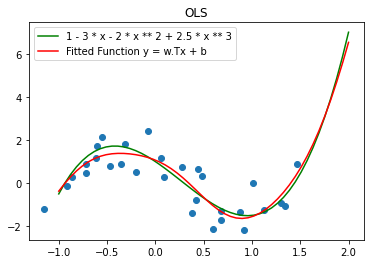

------------------------------------------------------------------------------------------------------------------------
Validation loss if 0.8690010458418722
Training Loss loss if 0.4543297001460214


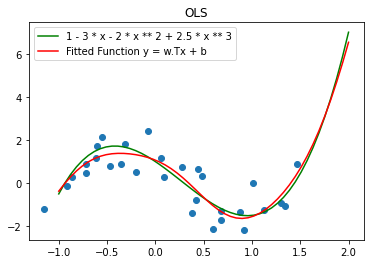

In [17]:
X_train, Y_train, X_test, Y_test = split_data(X_multi, Y_multi)

w, b = multivar_grad(X_train, Y_train, X_test, Y_test, epochs=1200, lr=0.1)

print('----' * 30)

w, b = multivar_closedform(X_train, Y_train, X_test, Y_test)

# Regularization

In [12]:

def multivar_reg_grad(X_train, Y_train, X_val, Y_val, epochs=1000, lr=0.1, lamda = 0.01):
    '''
    Perform L2 regularized multi variable least squares regression using gradient descent

    Args:
    X_train - numpy array of shape (n_samples_train, 5)
    Y_train - numpy array of shape (n_samples_train, 1)
    X_val - numpy array of shape (n_samples_val, 5)
    Y_val - numpy array of shape (n_samples_val, 1)
    epochs - number of gradient descent steps
    lr - learnig rate
    lamda - regularization weight
    '''

    w = [0.0] * X_train.shape[1]
    b = 0

    ## TODO

    n = len(Y_train) 
    w = np.array(w)
    for i in range(epochs):
        
        y_pred = np.dot(X_train, w) + b        
        dw = 2*(np.matmul((y_pred - Y_train), X_train))/n + 2*lamda*w
        db = 2*np.sum(y_pred - Y_train)/n
        w -= lr*dw
        b -= lr*db

    ## END TODO

    mse_train = mse_multi_var(X_train, Y_train, w, b)
    mse_val = mse_multi_var(X_val, Y_val, w, b)
    print(f'Validation loss if {mse_val}')
    print(f'Training Loss loss if {mse_train}')
    plot_curves(list(w), b, X_train, Y_train)
    return w, b


def multivar_reg_closedform(X_train, Y_train, X_val, Y_val, lamda=0.5):
    '''
    Perform L2 regularized multi variable least squares regression using 
    closed form update rules

    Args:
    X_train - numpy array of shape (n_samples_train, 5)
    Y_train - numpy array of shape (n_samples_train, 1)
    X_val - numpy array of shape (n_samples_val, 5)
    Y_val - numpy array of shape (n_samples_val, 1)
    lambda - regularization weight
    '''

    w = [0.0] * X_train.shape[1]
    b = 0

    ## TODO
    
    n = len(Y_train)
    w = np.array(w)
    X = np.hstack((X_train, np.ones((X_train.shape[0], 1), dtype=X_train.dtype)))
    w_b = np.dot(inv(np.dot(X.T, X) + n*lamda*np.identity(X.shape[1])), np.dot(X.T, Y_train)) 
    
    w = w_b[:-1]
    b = w_b[-1]   


    ## END TODO

    mse_train = mse_multi_var(X_train, Y_train, w, b)
    mse_val = mse_multi_var(X_val, Y_val, w, b)
    print(f'Validation loss if {mse_val}')
    print(f'Training Loss loss if {mse_train}')
    plot_curves(list(w), b, X_train, Y_train)
    return w, b


Validation loss if 0.89311128933525
Training Loss loss if 0.45956704941681725


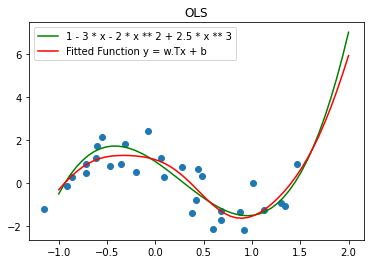

------------------------------------------------------------------------------------------------------------------------
Validation loss if 0.8986517057890268
Training Loss loss if 0.4598367886351609


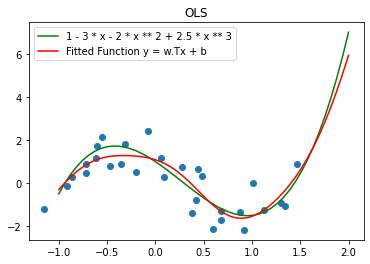

In [13]:
X_train, Y_train, X_val, Y_val = split_data(X_multi, Y_multi, train_ratio=0.6)

w, b = multivar_reg_grad(X_train, Y_train, X_val, Y_val, epochs = 1000, lr = 0.1, lamda=0.005)

print('----' * 30)

w, b = multivar_reg_closedform(X_train, Y_train, X_val, Y_val, lamda=0.005)

# Bayesian Linear Regression

As we studied in class, in Bayesian approach, we model the parameters of the model as a Random variable. 

We assume a (conjugate) prior distribution over the parameters ($p(w)$) and update  the posterior $p(w | D)$ based on the obervations.

In this assignment, we will assume that parameters are sampled from Gaussian distribution and try to learn the mean and variance of posterior.

Following the above discussion,

- let prior $p(w) = \mathcal{N}(\mu_0, \sum_0) = \mathcal{N}(0, 0.5)$
- We know that $p(w | \mathcal{D}) \propto p(w) P(\mathcal{D} | w)$
- Then, $p(w | \mathcal{D}) = \mathcal{N}(\mu_N, \sum_N)$
- And $p(\mathcal{D} | w) = \mathcal{N}(y| w^Tx, \sigma^2I)$

For this assignment, feel free to play with various values of $\sigma^2$ that gives you a better fit.

Finally the posterior parameters are given by, <br>
$\mu_N = \sum_N (\sum_0^{-1} \mu_0 + \frac{1}{\sigma^2}X^Ty)$ <br>
$\sum_N = (\sum_0^{-1} + \frac{1}{\sigma^2}X^TX)^{-1}$


### Learning Bias b
Eventhough the above formula shows how to compute $w$, we expect you to learn the bias $b$ also.

<font color='blue'> Hint: You can append a constant $1$ to all the input features $x$. Thus making the data $X \in \mathcal{R}^{d+1}$. </font>

In [14]:
def bayesion_lr(X_train, Y_train, X_val, Y_val):
    '''
    Perform Bayesian Linear Regression

    Args:
    X_train - numpy array of shape (n_samples_train, 5)
    Y_train - numpy array of shape (n_samples_train, 1)
    X_val - numpy array of shape (n_samples_val, 5)
    Y_val - numpy array of shape (n_samples_val, 1)
    '''

    ## TODO

    sigma_0 = 0.5
    mu_0 = 0
    X = np.hstack((X_train, np.ones((X_train.shape[0], 1), dtype=X_train.dtype)))    
    sigma = 0.2
    
    sigma_N = inv(1/sigma_0 + 1/(sigma**2) * np.dot(X.T, X))
    mu_N = np.dot(sigma_N, (mu_0/sigma_0 + 1/(sigma**2) * np.dot(X.T, Y_train)))
        
    w = list(mu_N[:-1])
    b = mu_N[-1]
    
#     mse_train = mse_multi_var(X_train, Y_train, w, b)
#     mse_val = mse_multi_var(X_val, Y_val, w, b)
#     print(f'Validation loss if {mse_val}')
#     print(f'Training Loss loss if {mse_train}')
    
    ## END TODO

    plot_curves(w, b, X_train, Y_train)
    return w, b

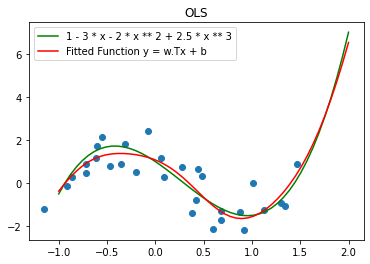

([-2.4411573562177544,
  -1.1096324404331148,
  1.8462728293190684,
  0.10370845179168377,
  0.46596096381498997],
 0.6096483649434978)

In [15]:
X_train, Y_train, X_val, Y_val = split_data(X_multi, Y_multi, train_ratio=0.6)

bayesion_lr(X_train, Y_train, X_val, Y_val)